In [113]:
## Bibliotecas

# Importacao e analise dos dados.
import pandas as pd
import numpy as np
from datetime import datetime

# Visualizacao dos dados.
import matplotlib.pyplot as plt
import seaborn as sns

# Classificadores
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

# Pre-processamento
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

# Avaliacao para a selecao do melhor modelo preditivo.
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import classification_report
from scipy.stats import ttest_ind # Teste T.

# Interpretabilidade.
import shap

# Ignorando warnings. Necessário para evitar a quantidade excessiva de warnings de convergência dos algoritmos.
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [114]:
# Importando dataset.
df = pd.read_csv('Myocardial_infarction_complications_Database.csv', na_values = '?')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Columns: 124 entries, ID to LET_IS
dtypes: float64(110), int64(14)
memory usage: 1.6 MB


# Pré-processamento inicial
> Observação: é gerado o dataframe ``df_bruto`` que corresponde ao dataframe inicial apenas com a binarização da classe alvo e o encoding das features categóricas com label encoder. Esse dataframe é utilizado no teste dos algoritmos de descida de gradiente com ensemble de árvores (XGBoost, CatBoost e LightGBM).

In [115]:
# 0 - Aplica a binarização do dataframe e exclui atributo ID.
y = df['LET_IS'].replace([2, 3, 4, 5, 6, 7], 1)
df = df.drop(df.columns[range(112,124)], axis = 1).drop(['ID'], axis = 1)
dfBruto = df.copy(deep=True)
# 1 - Exclui todas as colunas com mais de 10% de valores faltantes.

# Calcula a porcentagem de valores faltantes em cada coluna
missing_percentage = df.isnull().sum() / len(df)
# Filtra as colunas com mais de 10% de valores faltantes
columns_to_drop = missing_percentage[missing_percentage > 0.1].index
df_dropped = df.drop(columns=columns_to_drop)

# 2 - Exclui todas as colunas com dominância de um único valor superior a 95% 

# Calcula a porcentagem de valores dominantes em cada coluna
dominant_percentage = df_dropped.apply(lambda x: x.value_counts().max() / len(df_dropped))
# Filtra as colunas com dominância de um único valor superior a 95%
columns_to_drop = dominant_percentage[dominant_percentage > 0.95].index
df = df_dropped.drop(columns=columns_to_drop)

# 3 - Aplica label encode em todas as features categóricas.
# OBS: todas as features categóricas nominal já são binarias. Então, apenas aplicar o label encoder
# é suficiente.

features_numericas = ['AGE', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 
'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD','L_BLOOD', 'ROE']

le = LabelEncoder()
for column in df.columns:
    if column not in features_numericas:
        df[column] = le.fit_transform(df[column])
        dfBruto[column] = le.fit_transform(dfBruto[column])

In [116]:
# Apresenta dataframes finais.
print(df.info())
print(dfBruto.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AGE            1692 non-null   float64
 1   SEX            1700 non-null   int64  
 2   INF_ANAM       1700 non-null   int64  
 3   STENOK_AN      1700 non-null   int64  
 4   FK_STENOK      1700 non-null   int64  
 5   IBS_POST       1700 non-null   int64  
 6   GB             1700 non-null   int64  
 7   ZSN_A          1700 non-null   int64  
 8   endocr_01      1700 non-null   int64  
 9   zab_leg_01     1700 non-null   int64  
 10  zab_leg_02     1700 non-null   int64  
 11  O_L_POST       1700 non-null   int64  
 12  MP_TP_POST     1700 non-null   int64  
 13  ant_im         1700 non-null   int64  
 14  lat_im         1700 non-null   int64  
 15  inf_im         1700 non-null   int64  
 16  post_im        1700 non-null   int64  
 17  ritm_ecg_p_01  1700 non-null   int64  
 18  ritm_ecg

# Pipeline

In [117]:
def criaPipeline(classificador, features_numericas, features_categoricas, k_features=60):

  # Cria objeto da imputacao categorica.
  imputacaoCategorica = ColumnTransformer(
      transformers=[
          ('imputacao categorica', SimpleImputer(strategy='most_frequent'), features_categoricas)],
      remainder="passthrough")
  
  # Cria objeto da imputacao numerica.
  imputacaoNumerica = ColumnTransformer(
      transformers=[
          ('imputacao categorica', SimpleImputer(strategy='median'), features_numericas)],
      remainder="passthrough")

  # Padronizacao das features numericas.
  padronizacao = ColumnTransformer(
      transformers=[
          ('num_scaler', MinMaxScaler(), features_numericas)],
      remainder="passthrough")
    
  # Cria o pipeline com os passos a serem aplicados
  pipeline = imbPipeline(
          steps=[
              ('under_sampling', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
              ('imp_num', imputacaoNumerica),
              ('imp_cat', imputacaoCategorica),
              ('scaler', padronizacao),
              ('feature_selection', SelectKBest(score_func=chi2, k=k_features)),
              ('clf', classificador)
          ]
  )
  return pipeline

# Tuning dos modelos

In [118]:
# Espaço de hipêrparâmetros com pré-processamento.
# Passo a passo completo de como usar o XGBoost: https://www.kaggle.com/code/bextuychiev/20-burning-xgboost-faqs-answered-to-use-like-a-pro
# OBS: complexo suficiente para avaliar apenas o tuning dele no problema todo. Entretanto, vamos focar nos parâmetros mais comuns.
paramxgb = {
    'clf__n_estimators': [64, 128, 1000],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__max_depth': [3, 6, 10],
    'clf__min_child_weight': [1, 2, 5, 10],
    'clf__reg_alpha': [0, 0.01, 10, 100],
    'clf__reg_lambda': [0.01, 1, 10, 100],
    'clf__subsample': [0.5, 0.7, 0.9, 1.0],
    'feature_selection__k': [15, 35, 50]
}


paramgbm = {
    'clf__n_estimators': [64, 128, 1000],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__max_depth': [3, 6, 10],
    'clf__min_child_weight': [1, 2, 5, 10], 
    'clf__reg_alpha': [0, 0.01, 10, 100],
    'clf__reg_lambda': [0.01, 1, 10, 100],
    'clf__subsample': [0.5, 0.7, 0.9, 1.0],
    'clf__num_leaves': [5, 10, 31, 50], 
    'feature_selection__k': [15, 35, 50]
}

paramcat = {
    'clf__iterations': [64, 128, 1000],  
    'clf__learning_rate': [0.01, 0.1, 0.3],  
    'clf__depth': [5, 6, 10], 
    'clf__subsample': [0.5, 0.7, 0.9, 1.0],  
    'clf__colsample_bylevel': [0.05, 0.5, 1.0],  
    'clf__min_data_in_leaf': [1, 10, 100], 
    'clf__l2_leaf_reg': [1e5, 1e2, 0.01, 3, 10, 100],
    'feature_selection__k': [15, 35, 50]
}

# ------------------------------------------------------

parammlp = {
    'clf__hidden_layer_sizes' : [(50,), (100,), (150,)],
    'clf__learning_rate' : ['constant', 'adaptative'],
    'clf__max_iter' : [300, 500, 1000],
    'feature_selection__k': [15, 35, 50]
}

paramsvc = {
    'clf__kernel' : ['linear'],
    'clf__C' : [0.1, 1, 10, 100],
    'clf__gamma': [1],
    'clf__max_iter' : [100, 500, 1000],
    'feature_selection__k': [15, 35, 50]
}


paramlr = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 1, 10, 100],
    'clf__solver': ['newton-cg', 'lbfgs'],
    'feature_selection__k': [15, 35, 50]
}

# Algoritmos baseados em árvores.
# OBS: todos baseados em árvores, então define base boa de hiperparâmetros e copia.
paramdt = {
    'clf__min_samples_split': [2, 4, 8, 16, 32, 40], # Necessário começar em 2 (default). Segundo 1812.02207, 2-40
    'clf__min_samples_leaf': [1, 2, 4, 8, 16, 20], # Necessário começar em 1 (default). Segundo 1812.02207, 1-20
    'clf__max_features': [None, 'sqrt', 'log2'],
    'clf__criterion': ['gini', 'entropy'],
    'clf__splitter': ['best', 'random'],
    'feature_selection__k': [15, 35, 50]
}

paramrf = {
    'clf__min_samples_split': [2, 4, 8, 16, 32, 40],
    'clf__min_samples_leaf': [1, 2, 4, 8, 16, 20],
    'clf__max_features': [None, 'sqrt', 'log2'],
    'clf__criterion': ['gini', 'entropy'],
    'feature_selection__k': [15, 35, 50]
}

In [119]:
# Espaço de hipêrparâmetros sem pré-processamento.
paramxgbSemPre = {
    'n_estimators': [64, 128, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 2, 5, 10],
    'reg_alpha': [0, 0.01, 10, 100],
    'reg_lambda': [0.01, 1, 10, 100],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'scale_pos_weight': [2, 5.27, 8]
}

paramgbmSemPre = { 
    'n_estimators': [64, 128, 1000],
    'learning_rate': [0.01, 0.1, 0.3],  
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 2, 5, 10],  
    'reg_alpha': [0, 0.01, 10, 100],
    'reg_lambda': [0.01, 1, 10, 100],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'num_leaves': [5, 10, 31, 50], #
    'scale_pos_weight': [2, 5.27, 8]
}

paramcatSemPre = {
    'iterations': [64, 128, 1000],  
    'learning_rate': [0.01, 0.1, 0.3],  
    'depth': [5, 6, 10], 
    'subsample': [0.5, 0.7, 0.9, 1.0],  
    'colsample_bylevel': [0.05, 0.5, 1.0],  
    'min_data_in_leaf': [1, 10, 100], 
    'l2_leaf_reg': [1e5, 1e2, 0.01, 3, 10, 100],
    'scale_pos_weight': [2, 5.27, 8]
}

## Tuning dos modelos **com** pré-processamento dos dados

In [122]:
# Extraindo índices das colunas numéricas
features_numericas = np.where(df.dtypes == np.float64)[0]
# Extraindo índices das colunas categóricas
features_categoricas = np.where(df.dtypes == np.int64)[0]

# Criando pipeline para os modelos com pré-processamento.
pipeXgb = criaPipeline(xgb.XGBClassifier(random_state=42), features_numericas, features_categoricas)
pipeGbm = criaPipeline(lgb.LGBMClassifier(random_state=42), features_numericas, features_categoricas)
pipeCat = criaPipeline(CatBoostClassifier(random_state=42, verbose=False), features_numericas, features_categoricas)
pipeMlp = criaPipeline(MLPClassifier(), features_numericas, features_categoricas)
pipeSvc = criaPipeline(SVC(random_state=42), features_numericas, features_categoricas)
pipeLr = criaPipeline(LogisticRegression(random_state=42), features_numericas, features_categoricas)
pipeRf = criaPipeline(RandomForestClassifier(random_state=42, n_estimators=1000, n_jobs=-1), features_numericas, features_categoricas)
pipeDt = criaPipeline(DecisionTreeClassifier(random_state=42), features_numericas, features_categoricas)

# Criando GridSearchCV para tuning dos modelos com pré-processamento
grid_search_xgb = GridSearchCV(pipeXgb, paramxgb, cv=5, scoring = "f1", n_jobs=-1)
grid_search_gbm = GridSearchCV(pipeGbm, paramgbm, cv=5, scoring = "f1", n_jobs=-1)
grid_search_cat = GridSearchCV(pipeCat, paramcat, cv=5, scoring = "f1", n_jobs=-1)
grid_search_mlp = GridSearchCV(pipeMlp, parammlp, cv=5, scoring = "f1", n_jobs=-1)
grid_search_svc = GridSearchCV(pipeSvc, paramsvc, cv=5, scoring = "f1", n_jobs=-1)
grid_search_lr = GridSearchCV(pipeLr, paramlr, cv=5, scoring = "f1", n_jobs=-1)
grid_search_rf = GridSearchCV(pipeRf, paramrf, cv=5, scoring = "f1", n_jobs=-1)
grid_search_dt = GridSearchCV(pipeDt, paramdt, cv=5, scoring = "f1", n_jobs=-1)

# Dividir os dados em treinamento e teste pré-processados.
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)

In [123]:
# Tuning do LightGBM.
grid_search_gbm.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_gbm.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_gbm.best_score_)
y_pred = grid_search_gbm.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

exception calling callback for <Future at 0x7fecff747460 state=finished returned list>
Traceback (most recent call last):
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 360, in __call__
    self.parallel.dispatch_next()
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 797, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 864, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 782, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submi

KeyboardInterrupt: 

exception calling callback for <Future at 0x7fed8c494d00 state=finished returned list>
Traceback (most recent call last):
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 360, in __call__
    self.parallel.dispatch_next()
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 797, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 864, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 782, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submi

exception calling callback for <Future at 0x7fecff48e770 state=finished raised PicklingError>
Traceback (most recent call last):
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/queues.py", line 153, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/reduction.py", line 271, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/backend/reduction.py", line 264, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.py", line 602, in dump
    return Pickler.dump(self, obj)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 268, in __reduce__
    self._reducer_callback()
  File "/home/lar/anaconda3/lib/python3.10/site-pac

In [ ]:
# Tuning do XGBoost.
grid_search_xgb.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_xgb.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_xgb.best_score_)
y_pred = grid_search_xgb.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Tuning da CatBoost.
grid_search_cat.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_cat.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_cat.best_score_)
y_pred = grid_search_cat.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Best combination of parameters:
{'clf__criterion': 'entropy', 'clf__max_features': None, 'clf__min_samples_leaf': 16, 'clf__min_samples_split': 40, 'clf__splitter': 'best', 'feature_selection__k': 50}
Average accuracy (cross validation) of the best combination of parameters:
0.721703063177298
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       286
           1       0.62      0.57      0.60        54

    accuracy                           0.88       340
   macro avg       0.77      0.75      0.76       340
weighted avg       0.87      0.88      0.87       340



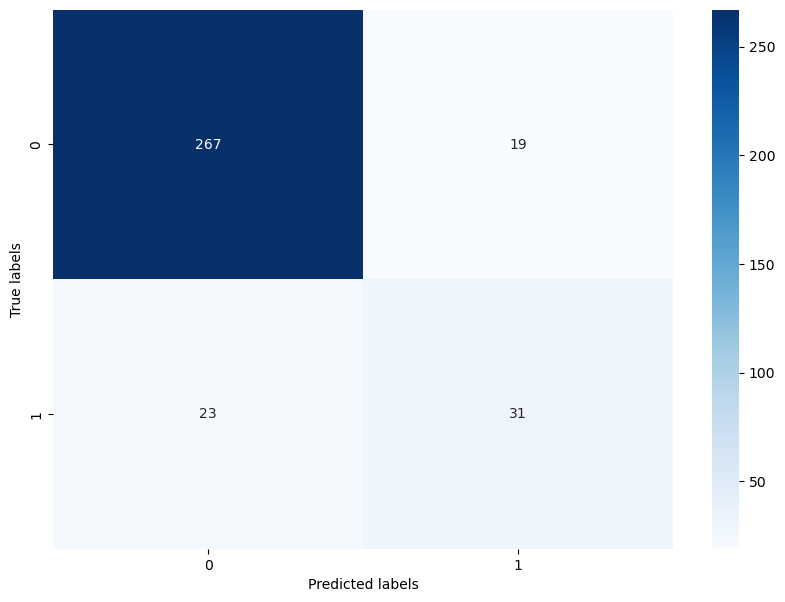

In [124]:
# Tuning da Decision Tree.
grid_search_dt.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_dt.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_dt.best_score_)
y_pred = grid_search_dt.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV 1/5; 570/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=16, feature_selection__k=50;, score=0.732 total time=   0.3s
[CV 3/5; 573/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=32, feature_selection__k=50
[CV 3/5; 573/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=32, feature_selection__k=50;, score=0.730 total time=   0.3s
[CV 2/5; 576/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=40, feature_selection__k=50
[CV 2/5; 576/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=40, feature_selection__k=50;, score=0.800 total time=   0.3s
[CV 4/5; 579/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=4, clf__m

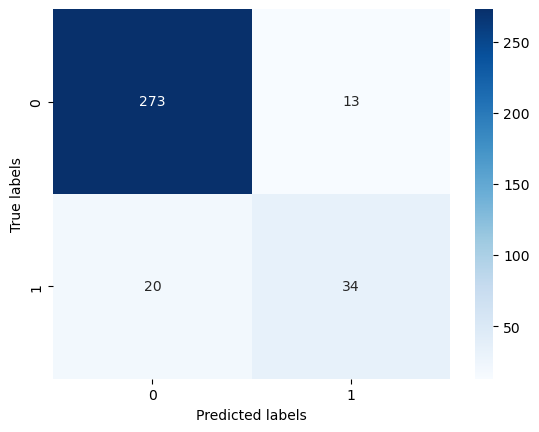

In [31]:
# Tuning da Random Forest.
grid_search_rf.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_rf.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_rf.best_score_)
y_pred = grid_search_rf.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages

[CV 5/5; 568/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=16, feature_selection__k=15;, score=0.737 total time=   2.5s
[CV 1/5; 572/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=32, feature_selection__k=35
[CV 1/5; 572/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=32, feature_selection__k=35;, score=0.740 total time=   2.1s
[CV 2/5; 575/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=40, feature_selection__k=35
[CV 2/5; 575/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=40, feature_selection__k=35;, score=0.769 total time=   2.5s
[CV 3/5; 578/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=2, feature_selection__k=35
[CV 3/5; 578/648] EN

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages

[CV 3/5; 635/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=4, feature_selection__k=35;, score=0.771 total time=   3.5s
[CV 4/5; 638/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=8, feature_selection__k=35
[CV 4/5; 638/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=8, feature_selection__k=35;, score=0.627 total time=   3.4s
[CV 5/5; 641/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=16, feature_selection__k=35
[CV 5/5; 641/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=16, feature_selection__k=35;, score=0.540 total time=   3.4s
[CV 5/5; 644/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=35
[CV 5/5; 644/648

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-package

[CV 4/5; 637/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=8, feature_selection__k=15;, score=0.686 total time=   3.4s
[CV 5/5; 640/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=16, feature_selection__k=15
[CV 5/5; 640/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=16, feature_selection__k=15;, score=0.627 total time=   3.5s
[CV 1/5; 644/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=35
[CV 1/5; 644/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=35;, score=0.557 total time=   3.4s
[CV 2/5; 647/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=40, feature_selection__k=35
[CV 2/5; 647/6

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-package

Best combination of parameters:
{'clf__hidden_layer_sizes': (50,), 'clf__learning_rate': 'constant', 'clf__max_iter': 300, 'feature_selection__k': 50}
Average accuracy (cross validation) of the best combination of parameters:
0.7036650211620621
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       286
           1       0.56      0.65      0.60        54

    accuracy                           0.86       340
   macro avg       0.75      0.78      0.76       340
weighted avg       0.87      0.86      0.87       340



/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


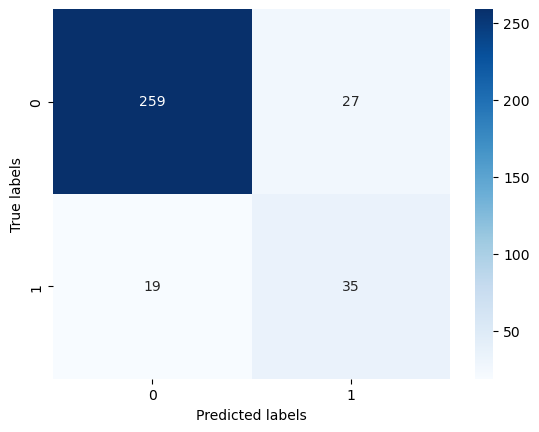

In [32]:
# Tuning da Mult Layer Perceptron.
grid_search_mlp.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_mlp.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_mlp.best_score_)
y_pred = grid_search_mlp.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 4/5; 636/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=4, feature_selection__k=50;, score=0.627 total time=   3.6s
[CV 5/5; 639/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=8, feature_selection__k=50
[CV 5/5; 639/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=8, feature_selection__k=50;, score=0.540 total time=   3.7s
[CV 2/5; 643/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=15
[CV 2/5; 643/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=15;, score=0.784 total time=   3.3s
[CV 3/5; 646/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver te

[CV 5/5; 643/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=15
[CV 5/5; 643/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=15;, score=0.627 total time=   3.2s
[CV 1/5; 647/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=40, feature_selection__k=35
[CV 1/5; 647/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=40, feature_selection__k=35;, score=0.557 total time=   3.1s
[CV 2/5; 2/54] START clf__hidden_layer_sizes=(50,), clf__learning_rate=constant, clf__max_iter=300, feature_selection__k=35
[CV 2/5; 2/54] END clf__hidden_layer_sizes=(50,), clf__learning_rate=constant, clf__max_iter=300, feature_selection__k=35;, score=0.697 total time=   0.4s
[CV 1/5; 5/54] START clf__hidden_layer_sizes=(50,), clf__learni

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver t

[CV 5/5; 642/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=16, feature_selection__k=50;, score=0.540 total time=   3.4s
[CV 1/5; 646/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=40, feature_selection__k=15
[CV 1/5; 646/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=40, feature_selection__k=15;, score=0.557 total time=   3.4s
[CV 2/5; 1/54] START clf__hidden_layer_sizes=(50,), clf__learning_rate=constant, clf__max_iter=300, feature_selection__k=15
[CV 2/5; 1/54] END clf__hidden_layer_sizes=(50,), clf__learning_rate=constant, clf__max_iter=300, feature_selection__k=15;, score=0.682 total time=   0.4s
[CV 2/5; 5/54] START clf__hidden_layer_sizes=(50,), clf__learning_rate=constant, clf__max_iter=500, feature_selection__k=35
[CV 2/5; 5/54] END clf__hidden_layer_sizes=(50,), clf__learning_rate=constant, clf__max_

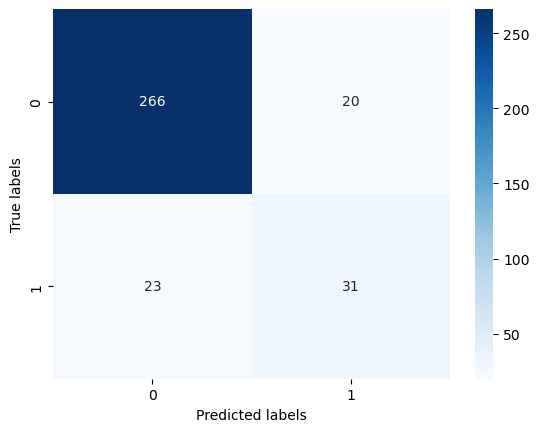

In [33]:
# Tuning do Support Vector Machine.
grid_search_svc.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_svc.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_svc.best_score_)
y_pred = grid_search_svc.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

[CV 5/5; 636/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=4, feature_selection__k=50
[CV 5/5; 636/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=4, feature_selection__k=50;, score=0.540 total time=   3.6s
[CV 2/5; 640/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=16, feature_selection__k=15
[CV 2/5; 640/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=16, feature_selection__k=15;, score=0.784 total time=   3.6s
[CV 4/5; 643/648] START clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=15
[CV 4/5; 643/648] END clf__criterion=entropy, clf__max_features=log2, clf__min_samples_leaf=20, clf__min_samples_split=32, feature_selection__k=15;, score=0.686 total time=   3.4s
[CV 5/5; 646/64

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Best combination of parameters:
{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'feature_selection__k': 35}
Average accuracy (cross validation) of the best combination of parameters:
0.7260215917842162
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       286
           1       0.62      0.56      0.59        54

    accuracy                           0.88       340
   macro avg       0.77      0.75      0.76       340
weighted avg       0.87      0.88      0.87       340



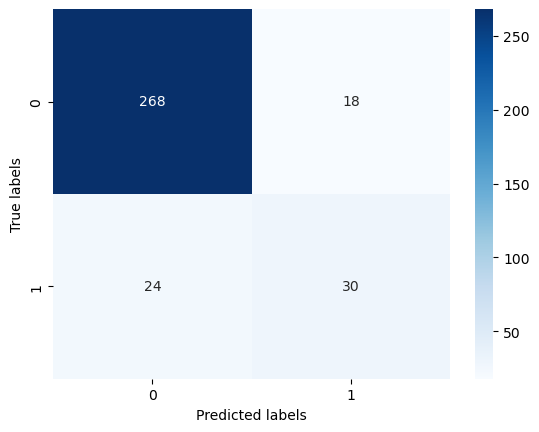

In [34]:
# Tuning da Logistic Regression.
grid_search_lr.fit(X_train, y_train)
print("Best combination of parameters:")
print(grid_search_lr.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_lr.best_score_)
y_pred = grid_search_lr.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Tuning dos modelos **sem** pré-processamento dos dados

In [126]:
# Criando objetos para os modelos.
pipeXgb = xgb.XGBClassifier(random_state=42)
pipeGbm = lgb.LGBMClassifier(random_state=42)
pipeCat = CatBoostClassifier(random_state=42, verbose=False)

# Criando GridSearchCV para tuning dos modelos com pré-processamento
grid_search_xgb = GridSearchCV(pipeXgb, paramxgbSemPre, cv=5, scoring = "f1", n_jobs=-1)
grid_search_gbm = GridSearchCV(pipeGbm, paramgbmSemPre, cv=5, scoring = "f1", n_jobs=-1)
grid_search_cat = GridSearchCV(pipeCat, paramcatSemPre, cv=5, scoring = "f1", n_jobs=-1)

# Dividir os dados em treinamento e teste sem pré-processamento.
X_train_sem_pre, X_test_sem_pre, y_train_sem_pre, y_test_sem_pre = train_test_split(dfBruto, y, test_size=0.2, random_state=42, stratify=y)

In [127]:
# Tuning do LightGBM.
grid_search_gbm.fit(X_train_sem_pre, y_train)
print("Best combination of parameters:")
print(grid_search_gbm.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_gbm.best_score_)
y_pred = grid_search_gbm.best_estimator_.predict(X_test_sem_pre)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Process LokyProcess-182:
Process LokyProcess-183:
Process LokyProcess-181:
Process LokyProcess-180:
Process LokyProcess-179:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 263, in __call__
    return [func(*args, **kwargs)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/joblib/parallel.py", line 263, in <listcomp>
    return [func(*args, **kwargs)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lar/anaconda3/lib/python3.10/site-packages/imble

KeyboardInterrupt: 

In [ ]:
# Tuning do CatBoost.
grid_search_cat.fit(X_train_sem_pre, y_train)
print("Best combination of parameters:")
print(grid_search_cat.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_cat.best_score_)
y_pred = grid_search_cat.best_estimator_.predict(X_test_sem_pre)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Tuning do XGBoost.
grid_search_xgb.fit(X_train_sem_pre, y_train)
print("Best combination of parameters:")
print(grid_search_xgb.best_params_)
print("Average accuracy (cross validation) of the best combination of parameters:")
print(grid_search_xgb.best_score_)
y_pred = grid_search_xgb.best_estimator_.predict(X_test_sem_pre)
report = classification_report(y_test, y_pred)
print(report)
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Avaliação dos modelos com 10-fold cross validation

In [128]:
# Extraindo índices das colunas numéricas
features_numericas = np.where(df.dtypes == np.float64)[0]
# Extraindo índices das colunas categóricas
features_categoricas = np.where(df.dtypes == np.int64)[0]

# Criando pipeline para os modelos com pré-processamento.
pipeXgb = criaPipeline(xgb.XGBClassifier(random_state=42, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=128, reg_alpha=0.01, reg_lambda=1, subsample=0.7), features_numericas, features_categoricas, 35)
pipeGbm = criaPipeline(lgb.LGBMClassifier(random_state=42, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=64, num_leaves=5, reg_alpha=0.01, reg_lambda=0.01, subsample=0.5), features_numericas, features_categoricas, 50)
pipeCat = criaPipeline(CatBoostClassifier(random_state=42, verbose=False, colsample_bylevel=0.5, depth=6, iterations=128, l2_leaf_reg=0.01, learning_rate=0.01, min_data_in_leaf=1, subsample=0.9), features_numericas, features_categoricas, 35)
pipeMlp = criaPipeline(MLPClassifier(hidden_layer_sizes=(50,), learning_rate='constant', max_iter=300), features_numericas, features_categoricas, 50)
pipeSvc = criaPipeline(SVC(random_state=42, C=0.1, gamma=1, kernel='linear', max_iter=1000), features_numericas, features_categoricas, 35)
pipeLr = criaPipeline(LogisticRegression(random_state=42, C=0.1, penalty='l2', solver='lbfgs'), features_numericas, features_categoricas, 35)
pipeRf = criaPipeline(RandomForestClassifier(random_state=42, n_estimators=1000, n_jobs=-1, criterion='entropy', max_features=None, min_samples_leaf=4, min_samples_split=2), features_numericas, features_categoricas, 50)
pipeDt = criaPipeline(DecisionTreeClassifier(random_state=42, criterion='entropy', max_features=None, min_samples_leaf=16, min_samples_split=40, splitter='best'), features_numericas, features_categoricas, 50)
# Criando objetos para os modelos sem pré-processamento.
clfXgb = xgb.XGBClassifier(random_state=42, learning_rate=0.01, max_depth=6, min_child_weight=2, n_estimators=1000, reg_alpha=0, reg_lambda=10, scale_pos_weight=5.27, subsample=0.5)
clfGbm = lgb.LGBMClassifier(random_state=42, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=128, num_leaves=10, reg_alpha=0.01, reg_lambda=10, scale_pos_weight=2, subsample=0.5)
clfCat = CatBoostClassifier(random_state=42, verbose=False, colsample_bylevel=0.5, depth=10, iterations=128, l2_leaf_reg=100.0, learning_rate=0.1, min_data_in_leaf=1, scale_pos_weight=5.27, subsample=1.0)

In [133]:
# Execucao do cross validation 10-fold para cada modelo.
# Com pré-processamento.
scoring = ['accuracy','f1_weighted','precision_weighted','recall_weighted', 'roc_auc']
scoresXgb = cross_validate(pipeXgb, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1) 
scoresGbm = cross_validate(pipeGbm, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresCat = cross_validate(pipeCat, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresMlp = cross_validate(pipeMlp, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresSvc = cross_validate(pipeSvc, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresLr = cross_validate(pipeLr, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresRf = cross_validate(pipeRf, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresDt = cross_validate(pipeDt, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
# Com sem pré-processamento.
scoresXgbSemPre = cross_validate(clfXgb, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1) 
scoresGbmSemPre = cross_validate(clfGbm, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresCatSemPre = cross_validate(clfCat, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages

In [130]:
# Execução do cross validation 10-fold para cada modelo com pré-processamento.
scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'roc_auc']
scoresXgb = cross_validate(pipeXgb, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1) 
scoresGbm = cross_validate(pipeGbm, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresCat = cross_validate(pipeCat, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresMlp = cross_validate(pipeMlp, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresSvc = cross_validate(pipeSvc, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresLr = cross_validate(pipeLr, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresRf = cross_validate(pipeRf, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresDt = cross_validate(pipeDt, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

# Com sem pré-processamento.
scoresXgbSemPre = cross_validate(clfXgb, X_train_sem_pre, y_train, cv=10, scoring=scoring, n_jobs=-1) 
scoresGbmSemPre = cross_validate(clfGbm, X_train_sem_pre, y_train, cv=10, scoring=scoring, n_jobs=-1)
scoresCatSemPre = cross_validate(clfCat, X_train_sem_pre, y_train, cv=10, scoring=scoring, n_jobs=-1)

/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lar/anaconda3/lib/python3.10/site-packages

In [134]:
# Criar um dataframe com 1 coluna para cada score e uma coluna para o nome do modelo
scoresList = []

scoresXgbDict = {'accuracy': scoresXgb['test_accuracy'].mean(),
                 'std-accuracy': scoresXgb['test_accuracy'].var(),
                 'f1-score': scoresXgb['test_f1_weighted'].mean(),
                 'std-f1-score': scoresXgb['test_f1_weighted'].var(),
                 'precision': scoresXgb['test_precision_weighted'].mean(),
                 'std-precision': scoresXgb['test_precision_weighted'].var(),
                 'recall': scoresXgb['test_recall_weighted'].mean(),
                 'std-recall': scoresXgb['test_recall_weighted'].var()}
scoresList.append(scoresXgbDict)

scoresGbmDict = {'accuracy': scoresGbm['test_accuracy'].mean(),
                 'std-accuracy': scoresGbm['test_accuracy'].var(),
                 'f1-score': scoresGbm['test_f1_weighted'].mean(),
                 'std-f1-score': scoresGbm['test_f1_weighted'].var(),
                 'precision': scoresGbm['test_precision_weighted'].mean(),
                 'std-precision': scoresGbm['test_precision_weighted'].var(),
                 'recall': scoresGbm['test_recall_weighted'].mean(),
                 'std-recall': scoresGbm['test_recall_weighted'].var()}
scoresList.append(scoresGbmDict)

scoresCatDict = {'accuracy': scoresCat['test_accuracy'].mean(),
                 'std-accuracy': scoresCat['test_accuracy'].var(),
                 'f1-score': scoresCat['test_f1_weighted'].mean(),
                 'std-f1-score': scoresCat['test_f1_weighted'].var(),
                 'precision': scoresCat['test_precision_weighted'].mean(),
                 'std-precision': scoresCat['test_precision_weighted'].var(),
                 'recall': scoresCat['test_recall_weighted'].mean(),
                 'std-recall': scoresCat['test_recall_weighted'].var()}
scoresList.append(scoresCatDict)

scoresMlpDict = {'accuracy': scoresMlp['test_accuracy'].mean(),
                 'std-accuracy': scoresMlp['test_accuracy'].var(),
                 'f1-score': scoresMlp['test_f1_weighted'].mean(),
                 'std-f1-score': scoresMlp['test_f1_weighted'].var(),
                 'precision': scoresMlp['test_precision_weighted'].mean(),
                 'std-precision': scoresMlp['test_precision_weighted'].var(),
                 'recall': scoresMlp['test_recall_weighted'].mean(),
                 'std-recall': scoresMlp['test_recall_weighted'].var()}
scoresList.append(scoresMlpDict)

scoresSvcDict = {'accuracy': scoresSvc['test_accuracy'].mean(),
                 'std-accuracy': scoresSvc['test_accuracy'].var(),
                 'f1-score': scoresSvc['test_f1_weighted'].mean(),
                 'std-f1-score': scoresSvc['test_f1_weighted'].var(),
                 'precision': scoresSvc['test_precision_weighted'].mean(),
                 'std-precision': scoresSvc['test_precision_weighted'].var(),
                 'recall': scoresSvc['test_recall_weighted'].mean(),
                 'std-recall': scoresSvc['test_recall_weighted'].var()}
scoresList.append(scoresSvcDict)

scoresLrDict = {'accuracy': scoresLr['test_accuracy'].mean(),
                'std-accuracy': scoresLr['test_accuracy'].var(),
                'f1-score': scoresLr['test_f1_weighted'].mean(),
                'std-f1-score': scoresLr['test_f1_weighted'].var(),
                'precision': scoresLr['test_precision_weighted'].mean(),
                'std-precision': scoresLr['test_precision_weighted'].var(),
                'recall': scoresLr['test_recall_weighted'].mean(),
                'std-recall': scoresLr['test_recall_weighted'].var()}
scoresList.append(scoresLrDict)

scoresRfDict = {'accuracy': scoresRf['test_accuracy'].mean(),
                'std-accuracy': scoresRf['test_accuracy'].var(),
                'f1-score': scoresRf['test_f1_weighted'].mean(),
                'std-f1-score': scoresRf['test_f1_weighted'].var(),
                'precision': scoresRf['test_precision_weighted'].mean(),
                'std-precision': scoresRf['test_precision_weighted'].var(),
                'recall': scoresRf['test_recall_weighted'].mean(),
                'std-recall': scoresRf['test_recall_weighted'].var()}
scoresList.append(scoresRfDict)

scoresDtDict = {'accuracy': scoresDt['test_accuracy'].mean(),
                'std-accuracy': scoresDt['test_accuracy'].var(),
                'f1-score': scoresDt['test_f1_weighted'].mean(),
                'std-f1-score': scoresDt['test_f1_weighted'].var(),
                'precision': scoresDt['test_precision_weighted'].mean(),
                'std-precision': scoresDt['test_precision_weighted'].var(),
                'recall': scoresDt['test_recall_weighted'].mean(),
                'std-recall': scoresDt['test_recall_weighted'].var()}
scoresList.append(scoresDtDict)

scoresXgbSemPreDict = {'accuracy': scoresXgbSemPre['test_accuracy'].mean(),
                'std-accuracy': scoresXgbSemPre['test_accuracy'].var(),
                'f1-score': scoresXgbSemPre['test_f1_weighted'].mean(),
                'std-f1-score': scoresXgbSemPre['test_f1_weighted'].var(),
                'precision': scoresXgbSemPre['test_precision_weighted'].mean(),
                'std-precision': scoresXgbSemPre['test_precision_weighted'].var(),
                'recall': scoresXgbSemPre['test_recall_weighted'].mean(),
                'std-recall': scoresXgbSemPre['test_recall_weighted'].var()}
scoresList.append(scoresXgbSemPreDict)

scoresGbmSemPreDict = {'accuracy': scoresGbmSemPre['test_accuracy'].mean(),
                'std-accuracy': scoresGbmSemPre['test_accuracy'].var(),
                'f1-score': scoresGbmSemPre['test_f1_weighted'].mean(),
                'std-f1-score': scoresGbmSemPre['test_f1_weighted'].var(),
                'precision': scoresGbmSemPre['test_precision_weighted'].mean(),
                'std-precision': scoresGbmSemPre['test_precision_weighted'].var(),
                'recall': scoresGbmSemPre['test_recall_weighted'].mean(),
                'std-recall': scoresGbmSemPre['test_recall_weighted'].var()}
scoresList.append(scoresGbmSemPreDict)

scoresCatSemPreDict = {'accuracy': scoresCatSemPre['test_accuracy'].mean(),
                'std-accuracy': scoresCatSemPre['test_accuracy'].var(),
                'f1-score': scoresCatSemPre['test_f1_weighted'].mean(),
                'std-f1-score': scoresCatSemPre['test_f1_weighted'].var(),
                'precision': scoresCatSemPre['test_precision_weighted'].mean(),
                'std-precision': scoresCatSemPre['test_precision_weighted'].var(),
                'recall': scoresCatSemPre['test_recall_weighted'].mean(),
                'std-recall': scoresCatSemPre['test_recall_weighted'].var()}
scoresList.append(scoresCatSemPreDict)

# Cria dataframe com as metricas para cada preditor.
dfScores = pd.DataFrame(scoresList)
dfScores['classificador'] = ['Xgb-pre', 'Gbm-pre', 'Cat-pre', 'Mlp-pre', 'Svc-pre', 'Lr-pre', 'Rf-pre', 'Dt-pre', 'Xgb-sem-pre', 'Gbm-sem-pre', 'Cat-sem-pre']
dfScores = dfScores.sort_values(by='f1-score', ascending=False)

# Apresenta 4 casas decimais.
pd.set_option('display.float_format', '{:.8f}'.format)
dfScores.head(11)

,accuracy,std-accuracy,f1-score,std-f1-score,precision,std-precision,recall,std-recall,classificador
9,0.92794118,0.00121972,0.92322449,0.00153494,0.92507876,0.00143173,0.92794118,0.00121972,Gbm-sem-pre
6,0.92426471,0.00114673,0.92196238,0.00130349,0.92234211,0.00140347,0.92426471,0.00114673,Rf-pre
2,0.92132353,0.00106023,0.91717986,0.00128985,0.91700602,0.00130510,0.92132353,0.00106023,Cat-pre
0,0.91911765,0.00109213,0.91678480,0.00122181,0.91672241,0.00126076,0.91911765,0.00109213,Xgb-pre
1,0.91691176,0.00109267,0.91616417,0.00117200,0.91693130,0.00127363,0.91691176,0.00109267,Gbm-pre
8,0.91544118,0.00117052,0.91543707,0.00119910,0.91700894,0.00128931,0.91544118,0.00117052,Xgb-sem-pre
10,0.90955882,0.00086559,0.90960949,0.00090560,0.91102785,0.00097758,0.90955882,0.00086559,Cat-sem-pre
5,0.90661765,0.00091966,0.90458776,0.00106830,0.90423983,0.00117032,0.90661765,0.00091966,Lr-pre
4,0.90441176,0.00094074,0.90265443,0.00109468,0.90231056,0.00123811,0.90441176,0.00094074,Svc-pre
7,0.89338235,0.00193826,0.89625221,0.00156311,0.90274989,0.00101099,0.89338235,0.00193826,Dt-pre


### Realizando test T para checar diferença estatistica entre os 2 melhores modelos

In [135]:
# Acessa vetor de f1 scores dos 2 modelos.
f1GbmSemPre = scoresGbmSemPre['test_f1_weighted']
f1Rf = scoresRf['test_f1_weighted']

# realiza o teste t.
_, p = ttest_ind(f1GbmSemPre, f1Rf)

# Imprime o resultado do teste.
if p <= 0.05:
    print("Há diferença estatisticamente significativa entre os valores de f1.")
    print(f"p: {p}")
else:
    print("Não há diferença estatisticamente significativa entre os valores de f1.")
    print(f"p: {p}")

Não há diferença estatisticamente significativa entre os valores de f1.
p: 0.9441268920059728


# Avaliação dos melhores modelos - LightGBM e Random Forest

Acurácia do LightGBM: 0.9176
Precisão do LightGBM: 0.9136
Recall do LightGBM: 0.9176
F1-score do LightGBM: 0.9116
Acurácia do Random Forest: 0.9029
Precisão do Random Forest: 0.8987
Recall do Random Forest: 0.9029
F1-score do Random Forest: 0.9002


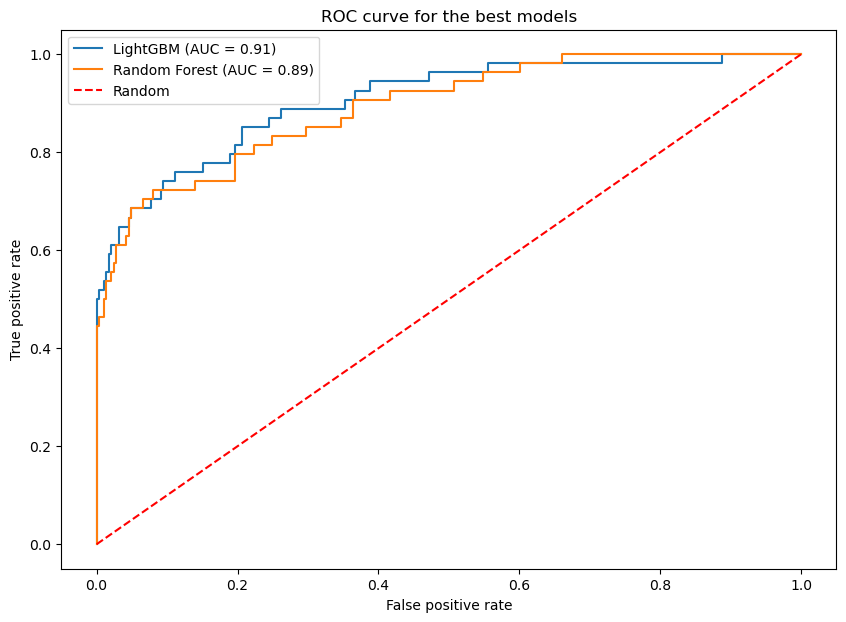

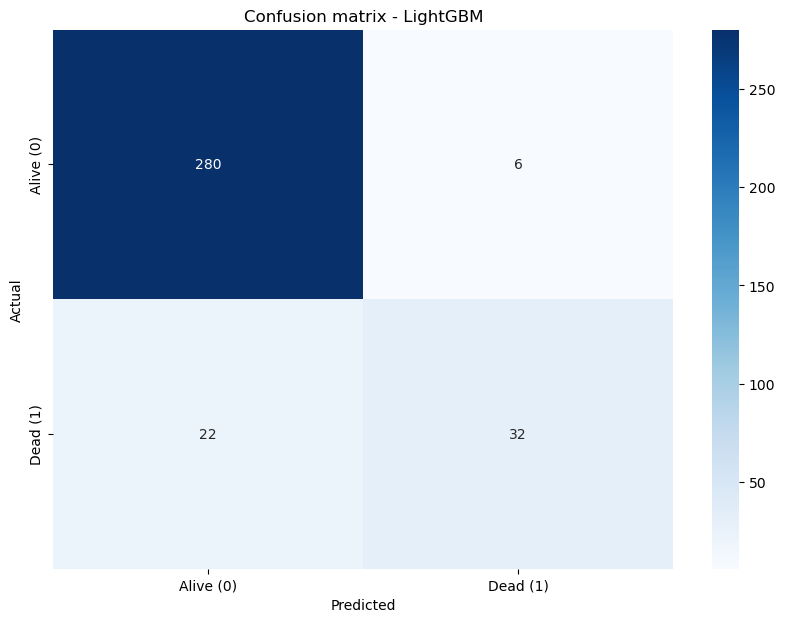

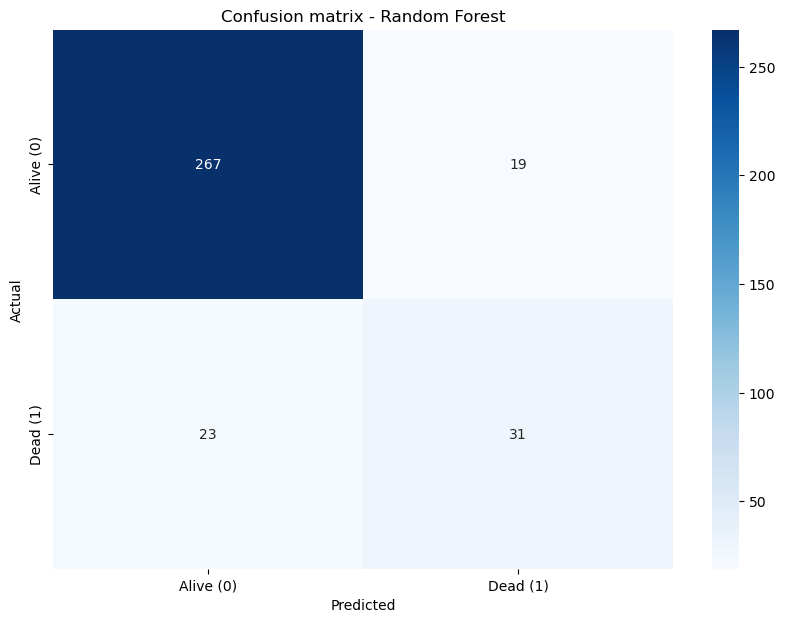

In [136]:
## Avaliacao do melhor modelo criado.

# Treina e testa o modelo.
clfGbm.fit(X_train_sem_pre, y_train)
y_pred_gbm  = clfGbm.predict(X_test_sem_pre)

# Calculando a acuracia do modelo
acuracia = accuracy_score(y_test, y_pred_gbm)
print(f'Acurácia do LightGBM: {acuracia.round(4)}')

# Calculando a precisao do modelo
precisao = precision_score(y_test, y_pred_gbm, average='weighted')
print(f'Precisão do LightGBM: {precisao.round(4)}')

# Calculando o revocacao do modelo
recall = recall_score(y_test, y_pred_gbm, average='weighted')
print(f'Recall do LightGBM: {recall.round(4)}')

# Calculando o F1-score do modelo
f1 = f1_score(y_test, y_pred_gbm, average='weighted')
print(f'F1-score do LightGBM: {f1.round(4)}')
# --------------------------------------

# Treina e testa o modelo.
pipeRf.fit(X_train, y_train)
y_pred_rf  = pipeRf.predict(X_test)

# Calculando a acuracia do modelo
acuracia = accuracy_score(y_test, y_pred_rf)
print(f'Acurácia do Random Forest: {acuracia.round(4)}')

# Calculando a precisao do modelo
precisao = precision_score(y_test, y_pred_rf, average='weighted')
print(f'Precisão do Random Forest: {precisao.round(4)}')

# Calculando o revocacao do modelo
recall = recall_score(y_test, y_pred_rf, average='weighted')
print(f'Recall do Random Forest: {recall.round(4)}')

# Calculando o F1-score do modelo
f1 = f1_score(y_test, y_pred_rf, average='weighted')
print(f'F1-score do Random Forest: {f1.round(4)}')
# --------------------------------------

# Plota o gráfico ROC do preditor final.
plt.rcParams['figure.figsize'] = [10, 7]
fig, ax = plt.subplots()

# Gera probabilidades das decisões.
y_pred_proba_gbm = clfGbm.predict_proba(X_test_sem_pre)
y_pred_proba_rf = pipeRf.predict_proba(X_test)

# Calcula a curva ROC e o AUC.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gbm[:, 1])
auc_score = auc(fpr, tpr)
# Plota a curva ROC.
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name='LightGBM').plot(ax=ax)
# Calcula a curva ROC e o AUC.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf[:, 1])
auc_score = auc(fpr, tpr)
# Plota a curva ROC.
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name='Random Forest').plot(ax=ax)
# Adiciona a reta do preditor aleatório (linha diagonal).
ax.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve for the best models')
plt.legend()
plt.show()


# Printa matriz de confusao
cm = confusion_matrix(y_test, y_pred_gbm)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Alive (0)', 'Dead (1)'],
            yticklabels=['Alive (0)', 'Dead (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - LightGBM")
plt.show()

# Printa matriz de confusao
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Alive (0)', 'Dead (1)'],
            yticklabels=['Alive (0)', 'Dead (1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - Random Forest")
plt.show()

# Interpretabilidade do modelo LightGBM com Tree SHAP

<Axes: title={'center': 'Feature Importance (split)'}, xlabel='Feature importance', ylabel='Features'>

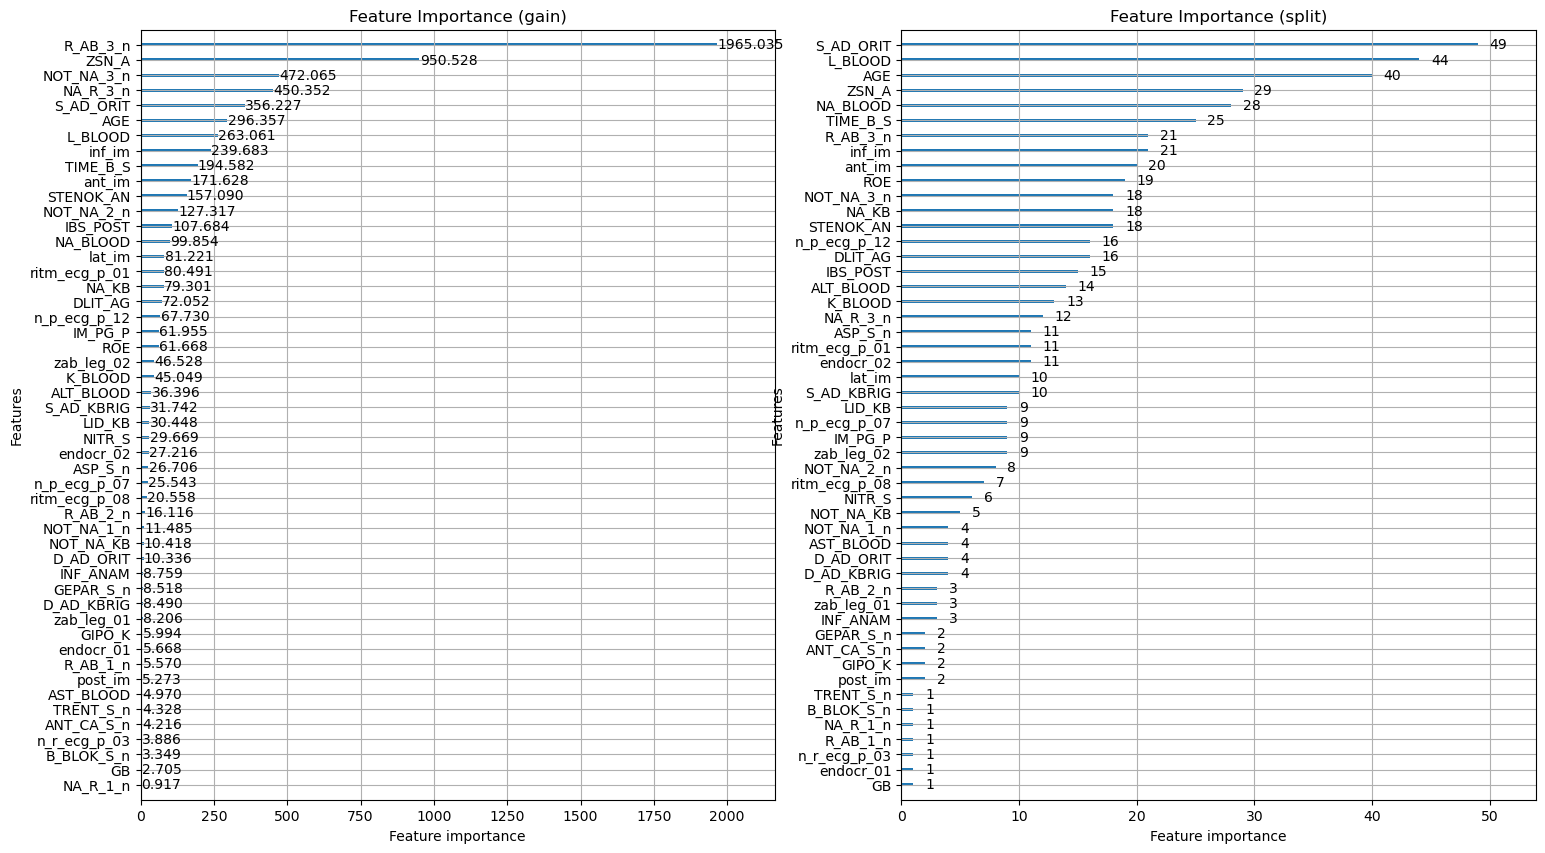

In [137]:
# Treina o modelo.
clfGbm.fit(X_train_sem_pre, y_train)
f, axs = plt.subplots(1, 2, figsize=(18,10))
lgb.plot_importance(clfGbm, importance_type='gain', title='Feature Importance (gain)', ax=axs[0])
lgb.plot_importance(clfGbm, importance_type='split', title='Feature Importance (split)', ax=axs[1])

In [138]:
# Criando objeto explainer do SHAP para o modelo LightGBM.
explainer = shap.TreeExplainer(model=clfGbm, data=None, model_output='raw', feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_test_sem_pre)

In [142]:
X_test_sem_pre.rename(columns={'S_AD_ORIT': 'Systolic blood pressure'}, inplace = True)
X_test_sem_pre.rename(columns={'TIME_B_S': 'Time elapsed from the beginning of the attack of CHD to the hospital'}, inplace = True)
X_test_sem_pre.rename(columns={'R_AB_3_n': 'Relapse of the pain in the third day of the hospital period'}, inplace = True)
X_test_sem_pre.rename(columns={'AGE': 'Age'}, inplace = True)
X_test_sem_pre.rename(columns={'L_BLOOD': 'White blood cell count'}, inplace = True)
X_test_sem_pre.rename(columns={'inf_im': 'Presence of an inferior myocardial infarction (left ventricular)'}, inplace = True)
X_test_sem_pre.rename(columns={'ant_im': 'Presence of an anterior myocardial infarction (left ventricular)'}, inplace = True)
X_test_sem_pre.rename(columns={'ZSN_A': 'Presence of chronic Heart failure (HF) in the anamnesis'}, inplace = True)
X_test_sem_pre.rename(columns={'IBS_POST': 'Coronary heart disease (CHD) in recent weeks, days before admission to hospital (IBS_POST)'}, inplace = True)
X_test_sem_pre.rename(columns={'NOT_NA_3_n': 'Use of NSAIDs in the ICU in the third day of the hospital period'}, inplace = True)
X_test_sem_pre.rename(columns={'NA_KB': 'Use of opioid drugs by the Emergency Cardiology Team'}, inplace = True)
X_test_sem_pre.rename(columns={'NA_R_3_n': 'Use of opioid drugs in the ICU in the third day of the hospital period'}, inplace = True)
X_test_sem_pre.rename(columns={'DLIT_AG': 'Duration of arterial hypertension'}, inplace = True)
X_test_sem_pre.rename(columns={'NOT_NA_2_n': 'Use of NSAIDs in the ICU in the second day of the hospital period'}, inplace = True)
X_test_sem_pre.rename(columns={'lat_im': 'Presence of a lateral myocardial infarction'}, inplace = True)
X_test_sem_pre.rename(columns={'ritm_ecg_p_01': 'ECG rhythm at the time of admission to hospital: sinus (with a heart rate 60-90)'}, inplace = True)
X_test_sem_pre.rename(columns={'n_p_ecg_p_12': 'Complete RBBB on ECG at the time of admission to hospital '}, inplace = True)
X_test_sem_pre.rename(columns={'NA_BLOOD': 'Serum sodium content'}, inplace = True)
X_test_sem_pre.rename(columns={'LID_KB': 'Use of lidocaine by the Emergency Cardiology Team'}, inplace = True)
X_test_sem_pre.rename(columns={'STENOK_AN': 'Exertional angina pectoris in the anamnesis'}, inplace = True)

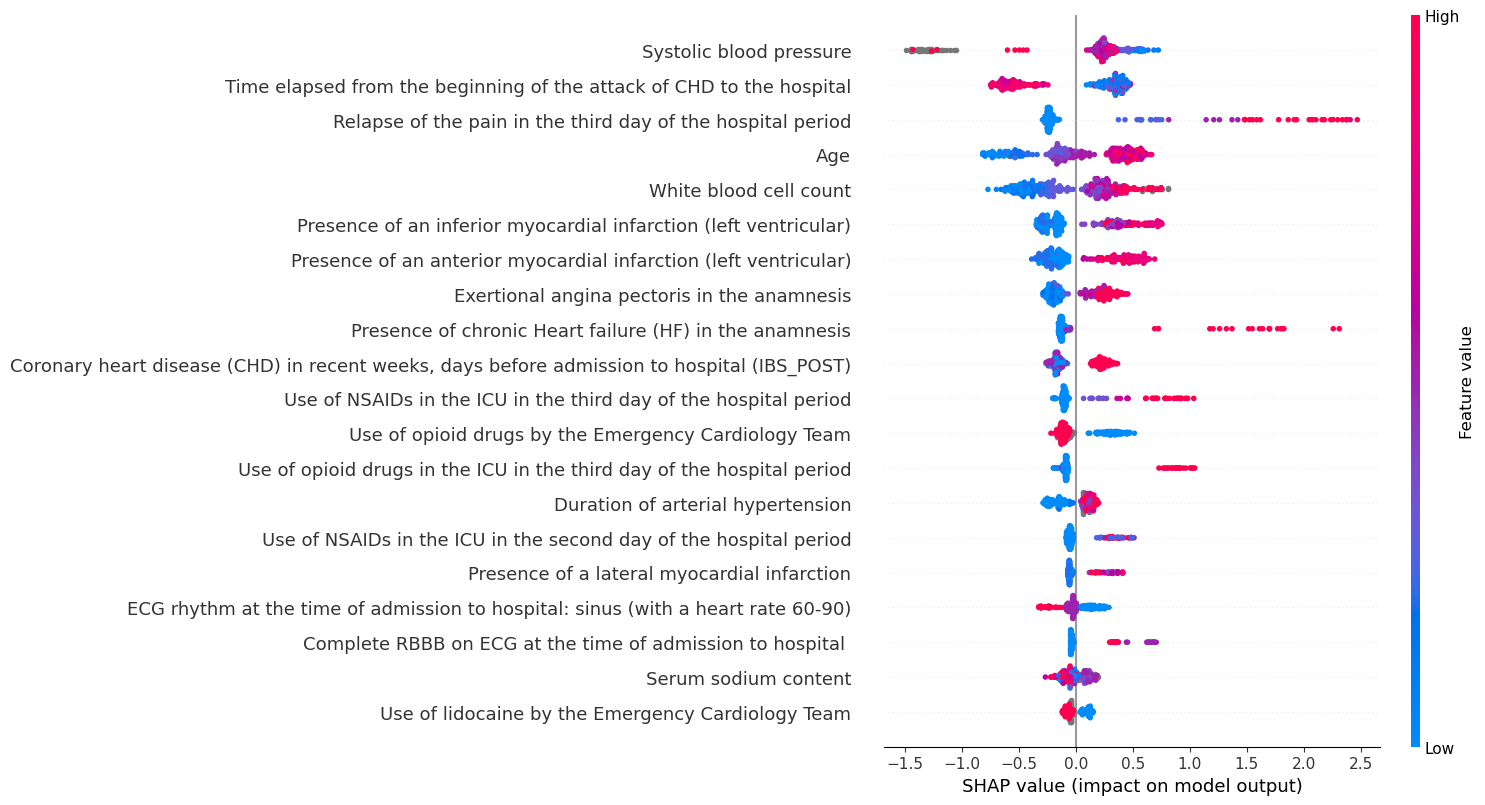

In [143]:
shap.summary_plot(shap_values[1], features=X_test_sem_pre)